# Putting It All Together

In this notebook, we'll build on lessons 1 and 2, and build a neural network used to classify hand-written digits. Most of the code here is based off of [https://github.com/dmlc/mxnet-notebooks/blob/master/python/basic/mixed.ipynb](https://github.com/dmlc/mxnet-notebooks/blob/master/python/basic/mixed.ipynb), if you need reference.

In [2]:
import mxnet as mx
num_classes = 10 # One class for each digit, 0-9

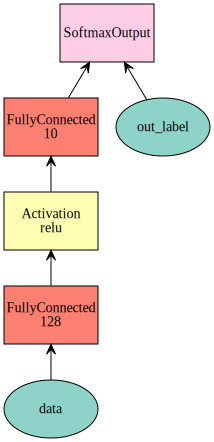

In [5]:
# Our network structure will include a fully connected layer with 128 hidden neurons, relu activation, 
# a fully connected layer with 10 hidden neurons, and finally an output layer with softmax normalization
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128) 
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net)

In [21]:
# Each of the fully connected layers include weights and biases. We can list those with `list_arguments`
print(net.list_arguments())

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']


### Binding

We now have variables (bias, weight) which must be bound to NDArrays before we can start using them in computations. The bind command accepts device context (ie CPU with `mx.cpu()` or GPU with `mx.gpu()`) and a `dict` mapping free variable names to NDArrays as arguments, and returns an executor. 

We can do the binding a couple of different ways: 1) Create NDArrays and bind to each, or 2) use the helper function `simple_bind`, which we'll do here:

In [22]:
num_features = 100
batch_size = 100
executor = net.simple_bind(ctx=mx.cpu(), data=(batch_size, num_features))
executor.arg_arrays

[<NDArray 100x100 @cpu(0)>,
 <NDArray 128x100 @cpu(0)>,
 <NDArray 128 @cpu(0)>,
 <NDArray 10x128 @cpu(0)>,
 <NDArray 10 @cpu(0)>,
 <NDArray 100 @cpu(0)>]

In [23]:
args = dict(zip(net.list_arguments(), executor.arg_arrays))
for name in args:
    print(name, args[name], args[name].shape)

('fc2_weight', <NDArray 10x128 @cpu(0)>, (10L, 128L))
('fc1_weight', <NDArray 128x100 @cpu(0)>, (128L, 100L))
('out_label', <NDArray 100 @cpu(0)>, (100L,))
('fc2_bias', <NDArray 10 @cpu(0)>, (10L,))
('data', <NDArray 100x100 @cpu(0)>, (100L, 100L))
('fc1_bias', <NDArray 128 @cpu(0)>, (128L,))


In [32]:
# Assign random values to weights, set bias to 0
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0

### Synthetic data

Before we can train, we need data to train with. We'll create that here

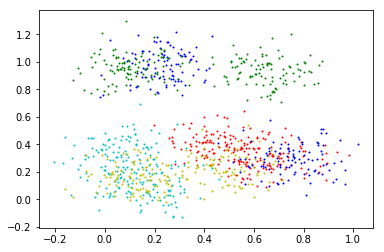

In [33]:
import numpy as np
import matplotlib.pyplot as plt
class ToyData:
    def __init__(self, num_classes, num_features):
        self.num_classes = num_classes
        self.num_features = num_features
        self.mu = np.random.rand(num_classes, num_features)
        self.sigma = np.ones((num_classes, num_features)) * 0.1
    def get(self, num_samples):
        num_cls_samples = num_samples / self.num_classes
        x = np.zeros((num_samples, self.num_features))
        y = np.zeros((num_samples, ))
        for i in range(self.num_classes):
            cls_samples = np.random.normal(self.mu[i,:], self.sigma[i,:], (num_cls_samples, self.num_features))
            x[i*num_cls_samples:(i+1)*num_cls_samples] = cls_samples
            y[i*num_cls_samples:(i+1)*num_cls_samples] = i
        return x, y
    def plot(self, x, y):
        colors = ['r', 'b', 'g', 'c', 'y']
        for i in range(self.num_classes):
            cls_x = x[y == i]
            plt.scatter(cls_x[:,0], cls_x[:,1], color=colors[i%5], s=1)
        plt.show()

toy_data = ToyData(num_classes, num_features)
x, y = toy_data.get(1000)
toy_data.plot(x,y)

In [34]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
learning_rate = 0.1
final_acc = 0
for i in range(100):
    x, y = toy_data.get(batch_size)
    args['data'][:] = x
    args['out_label'][:] = y
    executor.forward(is_train=True)
    executor.backward()
    for weight, grad in zip(ex.arg_arrays, ex.grad_arrays):
        weight[:] -= learning_rate * (grad / batch_size)
    if i % 10 == 0:
        acc = (mx.nd.argmax_channel(ex.outputs[0]).asnumpy() == y).sum()
        final_acc = acc
        print('iteration %d, accuracy %f' % (i, float(acc)/y.shape[0]))
assert final_acc > 0.95, "Low training accuracy."


iteration 0, accuracy 0.110000
iteration 10, accuracy 0.110000
iteration 20, accuracy 0.110000
iteration 30, accuracy 0.110000
iteration 40, accuracy 0.110000
iteration 50, accuracy 0.110000
iteration 60, accuracy 0.110000
iteration 70, accuracy 0.110000
iteration 80, accuracy 0.110000
iteration 90, accuracy 0.110000
